# Data Augmentation
Referências:
* Artigo: The Effectiveness of Data Augmentation in Image Classification using Deep Learning
* Tutorial TensorFlow: https://www.tensorflow.org/tutorials/images/data_augmentation


### Importar bibliotecas

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import uniform

### Conectar ao Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Definir diretório de imagens e rótulos
As imagens aumentadas serão armazenadas na mesma pasta, assim como os rótulos. No diretório passado para steps_dir será criado um arquivo de passos que armazenará todos os métodos utilizados para aumentar o dataset.

In [2]:
#data_dir = '/content/drive/MyDrive/UESC/TCC/TCCImages/YOLOTraining/images'
#label_dir = '/content/drive/MyDrive/UESC/TCC/TCCImages/YOLOTraining/labels'
#steps_dir = '/content/drive/MyDrive/UESC/TCC/TCCImages/YOLOTraining/'
data_dir = 'Soldas_ausente/'
step = 0

### Carregar o dataset utilizando TensorFlow
* Tutorial TensorFlow para carregar o dataset: https://www.tensorflow.org/tutorials/load_data/images

In [3]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3, dtype=tf.dtypes.uint8)
    # resize the image to the desired size
    return img

In [4]:
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [5]:
# Visualizar transformações aplicadas nas imagens
def visualize(images):
    fig = plt.figure()
    
    if len(images)==3:
        plt.figure(figsize=(15, 5))

        plt.subplot(1,3,1)
        plt.title('Fator Mínimo')
        plt.axis('off')
        plt.imshow(images[1])

        plt.subplot(1,3,2)
        plt.title('Imagem')
        plt.axis('off')
        plt.imshow(images[0])
    
        plt.subplot(1,3,3)
        plt.title('Fator Máximo')
        plt.axis('off')
        plt.imshow(images[2])
    
    else:
        plt.figure(figsize=(10, 5))

        plt.subplot(1,2,1)
        plt.title('Imagem')
        plt.axis('off')
        plt.imshow(images[0])

        plt.subplot(1,2,2)
        plt.title('Imagem Aumentada')
        plt.axis('off')
        plt.imshow(images[1])

In [6]:
# Lista arquivos do diretório de imagens
list_ds = tf.data.Dataset.list_files(str(data_dir+'Solda*'), shuffle=False)
for f in list_ds.take(5):
    image_name = str(f.numpy()).split("/")
    image_name = image_name[-1].split(".")[0]
    print(image_name)

Metal device set to: Apple M1
Solda_1
Solda_10
Solda_100
Solda_101
Solda_102


2022-12-01 20:48:12.674944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 20:48:12.675315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Mistura os arquivos listados
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
for f in list_ds.take(5):
    image_name = str(f.numpy()).split("/")
    image_name = image_name[-1].split(".")[0]
    print(image_name)

Solda_114
Solda_99
Solda_18
Solda_78
Solda_139


### Métodos de Data Augmentation
#### Entrada
Para cada método, valem os seguintes parâmetros:

* Lista com as images: list_ds
* Images Percentage: Percentagem das imagens que serão alteradas [0, 1]
* Interval Factor: Intervalo de valor em que as alterações serão realizadas

#### Saída
Cada método irá gerar arquivos de imagem e de texto que serão adicionados as mesmas pastas fornecidas no início do notebook.

### Rotacionar 90º
Rotate image(s) counter-clockwise by 90 degrees.

* https://www.tensorflow.org/api_docs/python/tf/image/rot90

In [ ]:
def rotate90(list_ds, images_percentage):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    # total de imagens a serem modificadas
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        augmented = tf.image.rot90(image)
        # nome da imagem no formato: arquivo/imagem.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar imagem na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-rot.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-rot.txt', 'w')
        for line in image_txt:
            line = line.split()
            aux = line[1]
            line[1] = line[2]
            line[2] = str(1-float(aux))
            augmented_txt.write(line[0]+' '+line[1]+' '+line[2]+' '+line[4]+' '+line[3])
            augmented_txt.write("\n")
        image_txt.close()
        augmented_txt.close()

In [ ]:
for f in list_ds.take(1):
    image = process_path(f.numpy())
    flipped = tf.image.rot90(image)
    visualize([image, flipped])

In [ ]:
images_percentage = 1
rotate90(list_ds, images_percentage)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Rotação\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == len(list_ds)*2

### Inverter horizontalmente
Flip an image horizontally (left to right).

* https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right

In [ ]:
def flip_left_right(list_ds, images_percentage):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        augmented = tf.image.flip_left_right(image)
        # nome da imagem formato: arquivo/image.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar imagem na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-h.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-h.txt', 'w')
        for line in image_txt:
            line = line.split()
            line[1] = str(1-float(line[1]))
            # line[2] = str(1-float(line[2]))
            i = 1
            for word in line:
                augmented_txt.write(word)
                if i != 5:
                    augmented_txt.write(" ")
                i += 1
            augmented_txt.write("\n")
        image_txt.close()
        augmented_txt.close()

In [ ]:
for f in list_ds.take(1):
    image = process_path(f.numpy())
    augmented = tf.image.flip_left_right(image)
    visualize([image, augmented])

In [ ]:
images_percentage = 1
flip_left_right(list_ds, images_percentage)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Inversão horizontal\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == len(list_ds)*3

### Inverter verticalmente
Flip an image vertically (upside down).

* https://www.tensorflow.org/api_docs/python/tf/image/flip_up_down

In [ ]:
def flip_up_down(list_ds, images_percentage):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada 
        augmented = tf.image.flip_up_down(image)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-v.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-v.txt', 'w')
        for line in image_txt:
            line = line.split()
            # line[1] = str(1-float(line[1]))
            line[2] = str(1-float(line[2]))
            i = 1
            for word in line:
                augmented_txt.write(word)
                if i != 5:
                    augmented_txt.write(" ")
                i += 1
            augmented_txt.write("\n")
        image_txt.close()
        augmented_txt.close()

In [ ]:
for f in list_ds.take(1):
    image = process_path(f.numpy())
    augmented = tf.image.flip_up_down(image)
    visualize([image, augmented])

In [ ]:
images_percentage = 1
flip_up_down(list_ds, images_percentage)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Inversão vertical\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == len(list_ds)*4 

In [ ]:
# atualiza a lista de imagens com as novas imagens obtidas com transformações geométricas
list_ds = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)


In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write("Adição das imagens transformadas geometricamente a lista de imagens que serão aumentadas\n")
steps.close()

### Saturação
Adjust saturation of RGB images.

* https://www.tensorflow.org/api_docs/python/tf/image/adjust_saturation

In [8]:
def saturation(list_ds, images_percentage, factor_interval):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        factor = round(uniform(factor_interval[0],factor_interval[1]), 2)
        augmented = tf.image.adjust_saturation(image, factor)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-sat'+str(factor)+'.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-sat'+str(factor)+'.txt', 'w')
        for line in image_txt:
            augmented_txt.write(line)
        image_txt.close()
        augmented_txt.close()

Defining factor interval

<Figure size 432x288 with 0 Axes>

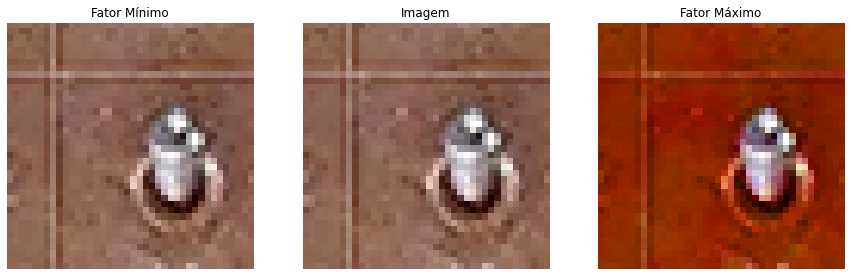

In [9]:
factor_interval=(1, 3)
for f in list_ds.take(1):
    image = process_path(f.numpy())
    augmented_1 = tf.image.adjust_saturation(image, factor_interval[0])
    augmented_2 = tf.image.adjust_saturation(image, factor_interval[1])
    visualize([image, augmented_1, augmented_2])

Augment images

In [10]:
images_percentage = 0.25
saturation(list_ds, images_percentage, factor_interval)
step += 1

NameError: name 'label_dir' is not defined

Write on steps file

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Saturação\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.write("Intervalo do fator: "+str(factor_interval)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*1.25)

### Brilho
Adjust the brightness of RGB or Grayscale images.

* https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness

In [11]:
def brightness(list_ds, images_percentage, factor_interval):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        factor = round(uniform(factor_interval[0],factor_interval[1]), 2)
        augmented = tf.image.adjust_brightness(image, factor)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-bright'+str(factor)+'.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-bright'+str(factor)+'.txt', 'w')
        for line in image_txt:
            augmented_txt.write(line)
        image_txt.close()
        augmented_txt.close()

<Figure size 432x288 with 0 Axes>

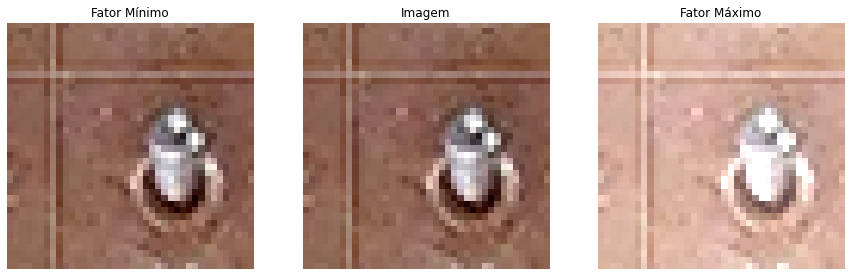

In [12]:
factor_interval=(0, 0.3)
for f in list_ds.take(1):
    image = process_path(f.numpy())
    augmented_1 = tf.image.adjust_brightness(image, factor_interval[0])
    augmented_2 = tf.image.adjust_brightness(image, factor_interval[1])
    visualize([image, augmented_1, augmented_2])


In [ ]:
images_percentage = 0.25
brightness(list_ds, images_percentage, factor_interval)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Brilho\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.write("Intervalo do fator: "+str(factor_interval)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*1.5)

### Contraste
Adjust contrast of RGB or grayscale images.

* https://www.tensorflow.org/api_docs/python/tf/image/adjust_contrast

In [13]:
def contrast(list_ds, images_percentage, factor_interval):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        factor = round(uniform(factor_interval[0],factor_interval[1]), 2)
        augmented = tf.image.adjust_contrast(image, factor)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-contrast'+str(factor)+'.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-contrast'+str(factor)+'.txt', 'w')
        for line in image_txt:
            augmented_txt.write(line)
        image_txt.close()
        augmented_txt.close()

<Figure size 432x288 with 0 Axes>

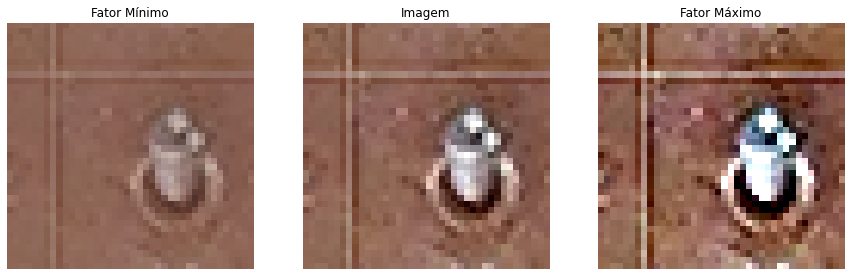

<Figure size 432x288 with 0 Axes>

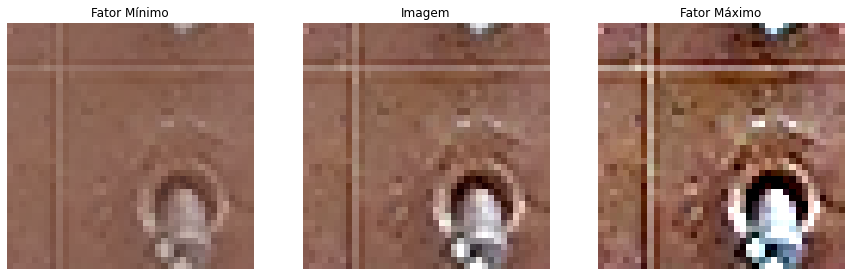

<Figure size 432x288 with 0 Axes>

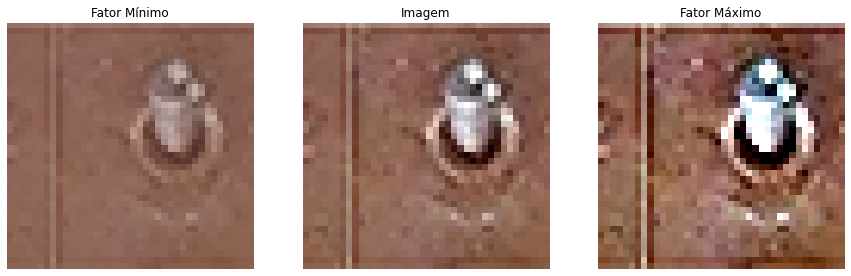

<Figure size 432x288 with 0 Axes>

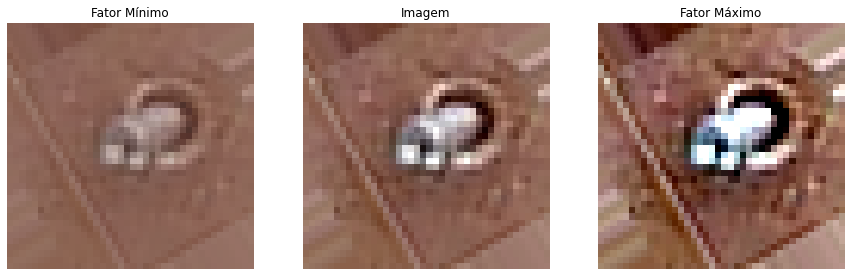

<Figure size 432x288 with 0 Axes>

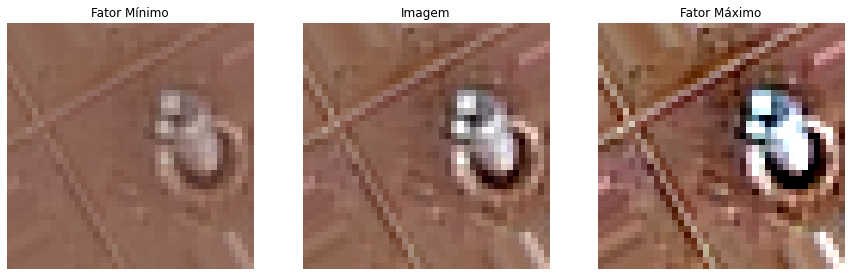

In [14]:
factor_interval=(0.5, 2)
for f in list_ds.take(5):
    image = process_path(f.numpy())
    augmented_1 = tf.image.adjust_contrast(image, factor_interval[0])
    augmented_2 = tf.image.adjust_contrast(image, factor_interval[1])
    visualize([image, augmented_1, augmented_2])

In [ ]:
images_percentage = 0.25
contrast(list_ds, images_percentage, factor_interval)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Contraste\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.write("Intervalo do fator: "+str(factor_interval)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*1.75)

### Gamma
Performs Gamma Correction.

* https://www.tensorflow.org/api_docs/python/tf/image/adjust_gamma

In [15]:
def gamma(list_ds, images_percentage, factor_interval):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        factor = round(uniform(factor_interval[0],factor_interval[1]), 2)
        augmented = tf.image.adjust_gamma(image, factor)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-gamma'+str(factor)+'.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-gamma'+str(factor)+'.txt', 'w')
        for line in image_txt:
            augmented_txt.write(line)
        image_txt.close()
        augmented_txt.close()

<Figure size 432x288 with 0 Axes>

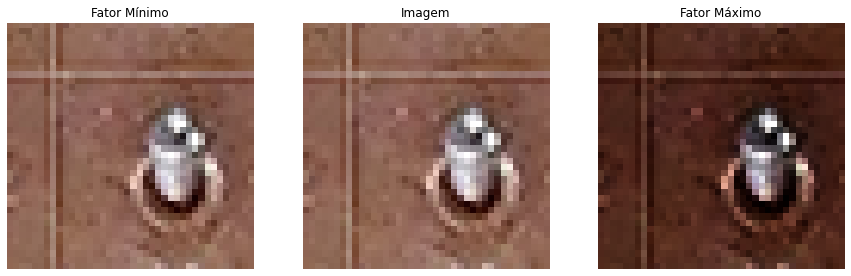

In [16]:
factor_interval=(1, 2)
for f in list_ds.take(1):
    image = process_path(f.numpy())
    augmented_1 = tf.image.adjust_gamma(image, factor_interval[0])
    augmented_2 = tf.image.adjust_gamma(image, factor_interval[1])
    visualize([image, augmented_1, augmented_2])

In [ ]:
images_percentage = 0.25
gamma(list_ds, images_percentage, factor_interval)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Gamma\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.write("Intervalo do fator: "+str(factor_interval)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*2)

### Suavização pela Média
* https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html

In [21]:
import cv2 as cv

In [22]:
def averaging(list_ds, images_percentage, factor_interval):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        factor = round(uniform(factor_interval[0],factor_interval[1])) # nesse caso tem que ser int
        image = np.asarray(image)
        augmented = cv.blur(image,(factor, factor))
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-averageblur'+str(factor)+'.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-averageblur'+str(factor)+'.txt', 'w')
        for line in image_txt:
            augmented_txt.write(line)
        image_txt.close()
        augmented_txt.close()

<Figure size 432x288 with 0 Axes>

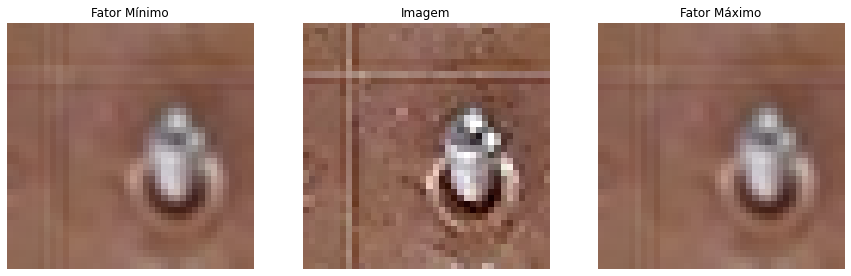

In [23]:
factor_interval=(3, 3)
for f in list_ds.take(1):
    image = process_path(f.numpy())
    image = np.asarray(image)
    augmented_1 = cv.blur(image,(factor_interval[0], factor_interval[0]))
    augmented_2 = cv.blur(image,(factor_interval[1], factor_interval[1]))
    visualize([image, augmented_1, augmented_2])

In [ ]:
images_percentage = 0.25
averaging(list_ds, images_percentage, factor_interval)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Suavização pela média\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.write("Intervalo do fator: "+str(factor_interval)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*2.25)

### Suavização Gaussiana
* https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html

In [24]:
def gaussian_blurr(list_ds, images_percentage, factor_interval):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        factor = round(uniform(factor_interval[0],factor_interval[1])) # nesse caso tem que ser ímpar
        if factor % 2 == 0:
            factor += 1
        image = np.asarray(image)
        augmented = cv.GaussianBlur(image,(factor, factor), 0)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-gaussianblur'+str(factor)+'.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-gaussianblur'+str(factor)+'.txt', 'w')
        for line in image_txt:
            augmented_txt.write(line)
        image_txt.close()
        augmented_txt.close()

<Figure size 432x288 with 0 Axes>

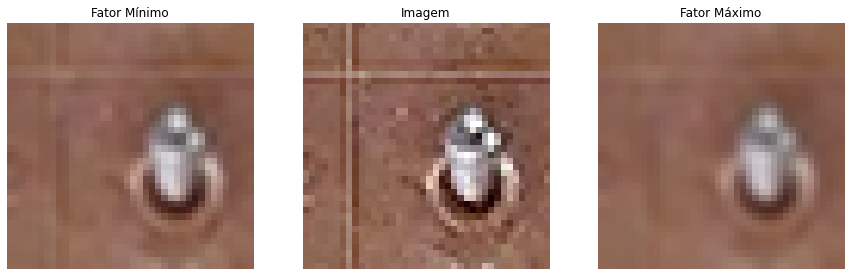

<Figure size 432x288 with 0 Axes>

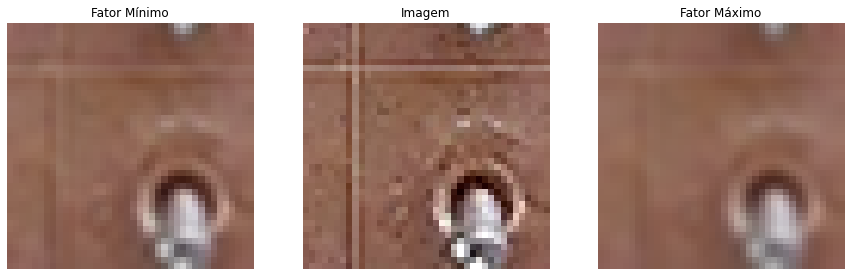

<Figure size 432x288 with 0 Axes>

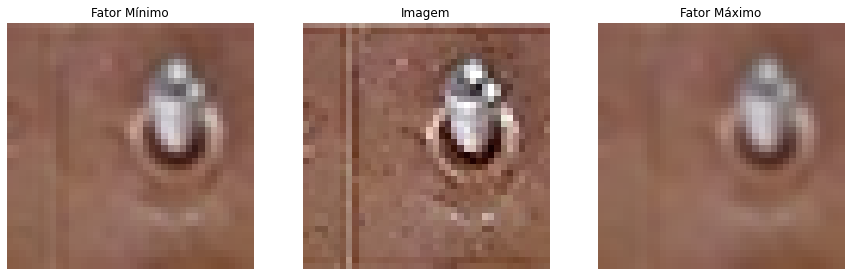

<Figure size 432x288 with 0 Axes>

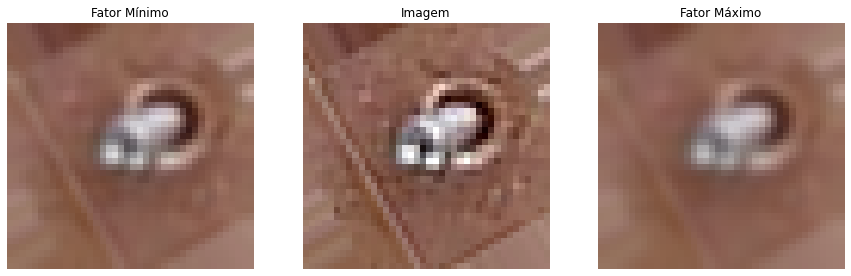

<Figure size 432x288 with 0 Axes>

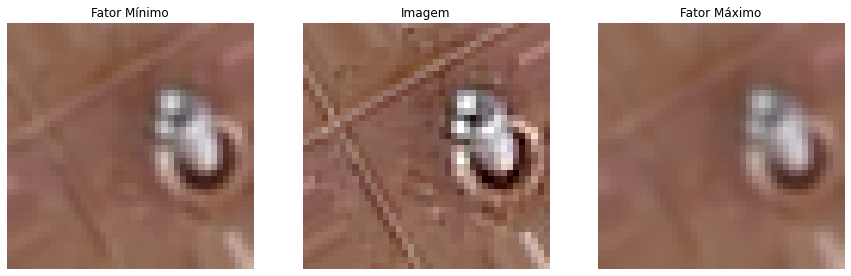

In [25]:
factor_interval=(3, 5)
for f in list_ds.take(5):
    image = process_path(f.numpy())
    image = np.asarray(image)
    augmented_1 = cv.GaussianBlur(image,(factor_interval[0], factor_interval[0]), 0)
    augmented_2 = cv.GaussianBlur(image,(factor_interval[1], factor_interval[1]), 0)
    visualize([image/255, augmented_1, augmented_2])

In [ ]:
images_percentage = 0.25
gaussian_blurr(list_ds, images_percentage, factor_interval)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Suavização Gaussiana\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.write("Intervalo do fator: "+str(factor_interval)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*2.5)

### Suavização pela mediana
* https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html

In [26]:
def median_blurr(list_ds, images_percentage, factor_interval):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        factor = round(uniform(factor_interval[0],factor_interval[1])) # nesse caso tem que ser impar
        if factor % 2 == 0:
            factor += 1
        image = np.asarray(image)
        augmented = cv.medianBlur(image, factor)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-medianblur'+str(factor)+'.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-medianblur'+str(factor)+'.txt', 'w')
        for line in image_txt:
            augmented_txt.write(line)
        image_txt.close()
        augmented_txt.close()

<Figure size 432x288 with 0 Axes>

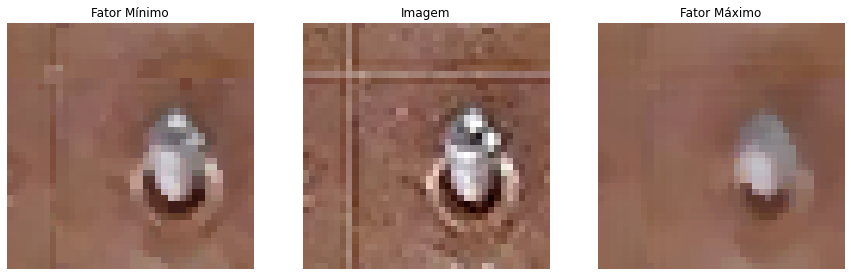

<Figure size 432x288 with 0 Axes>

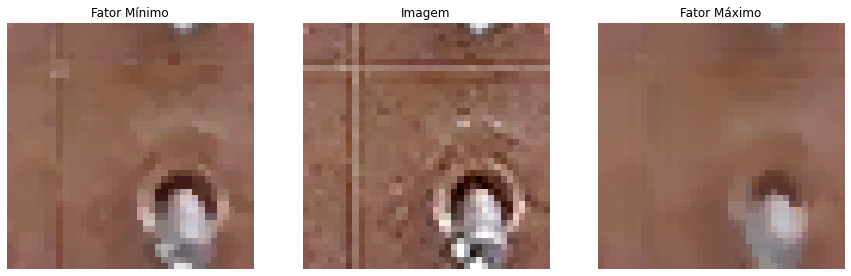

<Figure size 432x288 with 0 Axes>

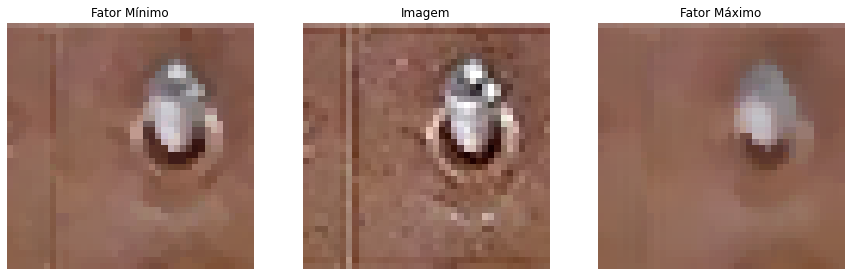

In [27]:
factor_interval=(3, 5)
for f in list_ds.take(3):
    image = process_path(f.numpy())
    image = np.asarray(image)
    augmented_1 = cv.medianBlur(image,factor_interval[0])
    augmented_2 = cv.medianBlur(image,factor_interval[1])
    visualize([image/255, augmented_1, augmented_2])

In [ ]:
images_percentage = 0.25
median_blurr(list_ds, images_percentage, factor_interval)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Suavização pela mediana\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.write("Intervalo do fator: "+str(factor_interval)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*2.75)

### Gaussian Noise
* https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/

In [28]:
def gaussian_noise(list_ds, images_percentage, factor_interval):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterad
        factor = round(uniform(factor_interval[0],factor_interval[1]), 2)
        image = tf.cast(image/255, tf.float32)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=factor, dtype=tf.float32)
        augmented = tf.add(image, noise)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-gaussnoise'+str(factor)+'.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=True
        )
        # salvar novos rótulos
        image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
        augmented_txt = open(label_dir+'/'+image_name+'-gaussnoise'+str(factor)+'.txt', 'w')
        for line in image_txt:
            augmented_txt.write(line)
        image_txt.close()
        augmented_txt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

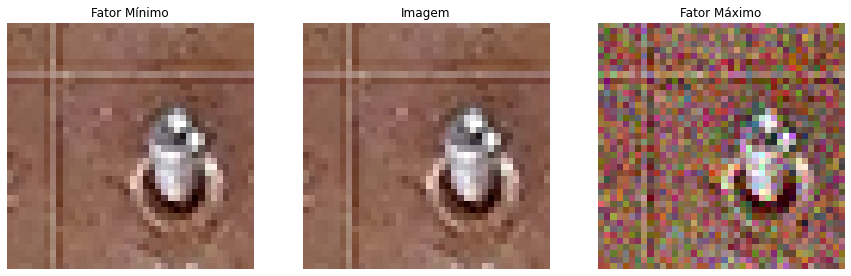

In [29]:
factor_interval = (0, 0.10)
for f in list_ds.take(1):
    image = process_path(f.numpy())
    image = tf.cast(image/255, tf.float32)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=factor_interval[0], dtype=tf.float32)
    augmented_1 = tf.add(image, noise)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=factor_interval[1], dtype=tf.float32)
    augmented_2 = tf.add(image, noise)
    visualize([image, augmented_1, augmented_2])

In [ ]:
images_percentage = 0.25
gaussian_noise(list_ds, images_percentage, factor_interval)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Gaussian Noise\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.write("Intervalo do fator: "+str(factor_interval)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*3)

### Cutout
* Cutout https://www.kaggle.com/kaushal2896/data-augmentation-tutorial-basic-cutout-mixup
* IoU https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation


In [ ]:
# Imagens = 780x540 mais ou menos
import random
import cv2 as cv

def cutout_process(image, image_name):
    # parametros
    fill_value=0
    bbox_removal_threshold=0.50
    min_cutout_size=16
    max_cutout_size=64
    
    image_width = image.shape[1]
    image_height = image.shape[0]
    
    # número de cutouts
    n_cuts = random.randint(3, 6)
    
    # lista de bboxes
    bboxes = []
    image_txt = open(label_dir+'/'+image_name+'.txt', 'r')
    for line in image_txt:
        line = line.split()
        classe = int(line[0])
        x = int(float(line[1])*image_width)
        y = int(float(line[2])*image_height)
        width = int(float(line[3])*image_width)
        height = int(float(line[4])*image_height)
        bboxes.append([x, y, width, height, classe])
    image_txt.close()
    
    for i in range(n_cuts):
        x = random.randint(0, image_width-max_cutout_size)
        y = random.randint(0, image_height-max_cutout_size)
        width = random.randint(min_cutout_size, max_cutout_size)
        height = random.randint(min_cutout_size, max_cutout_size)
        xmax = x+width
        ymax = y+height

        if xmax > image_width:
            xmax = image_width
        if ymax > image_height:
            ymax = image_height
            
        cv.rectangle(image,(x,y),(xmax,ymax),(0,0,0),-1)
    
    augmented_txt = open(label_dir+'/'+image_name+'-cutout.txt', 'w')
    for bbox in bboxes:
        preto = 0
        x = bbox[0]
        y = bbox[1]
        width = bbox[2]
        height = bbox[3]
        for i in range(y-int(height/2),y+int(height/2)):
            for j in range(x-int(width/2),x+int(width/2)):
                if image[i][j].all()==0:
                    preto+=1
                else:
                    preto-=1
        if preto < 0:
            augmented_txt.write(str(bbox[4])+" ")
            augmented_txt.write(str(x/image_width)+" ")
            augmented_txt.write(str(y/image_height)+" ")
            augmented_txt.write(str(width/image_width)+" ")
            augmented_txt.write(str(height/image_height)+"\n")
    augmented_txt.close()
    
    return image

In [ ]:
def cutout(list_ds, images_percentage):
    #shuffle
    num_images = len(list_ds)
    list_ds = list_ds.shuffle(num_images, reshuffle_each_iteration=False)
    total = round(num_images*images_percentage)
    for f in list_ds.take(total):
        # pegar a imagem
        image = process_path(f.numpy())
        # imagem alterada
        image = np.asarray(image)
        # nome da imagem formato: arquivo/nome.xxx
        image_name = str(f.numpy()).split("/")
        image_name = image_name[-1].split(".")[0]
        augmented = cutout_process(image.copy(), image_name)
        # salvar na pasta
        tf.keras.preprocessing.image.save_img(
            path=data_dir+'/'+image_name+'-cutout.png', 
            x=augmented,
            data_format='channels_last',
            file_format='png', 
            scale=False
        )

In [ ]:
for f in list_ds.take(1):
    image = process_path(f.numpy())
    image = np.asarray(image)
    image_name = str(f.numpy()).split("/")
    image_name = image_name[-1].split(".")[0]
    augmented_1 = cutout_process(image.copy(), image_name)
    augmented_2 = cutout_process(image.copy(), image_name)
    visualize([image, augmented_1, augmented_2])

In [ ]:
images_percentage = 0.25
cutout(list_ds, images_percentage)
step += 1

In [ ]:
# escrever no arquivo de passos o que foi feito
steps = open(steps_dir+"augmentation-steps.txt", "a")
steps.write(str(step)+". Cutout\nPercentagem das imagens utilizadas: "+str(images_percentage)+"\n")
steps.close()

In [ ]:
# verificar se o numero total de imagens está correto
list_assert = tf.data.Dataset.list_files(str(data_dir+'*/*'), shuffle=False)
assert len(list_assert) == round(len(list_ds)*3.25)

In [ ]:
print("Total")
print(len(list_assert))